# Package

In [14]:
#=
Traduction Julia du script Python échantillonnant les configurations de Bethe dans un GGE
=#
#import Pkg; Pkg.add("StatsBase")
#import Pkg; Pkg.add("Plots")
#import Pkg; Pkg.add("LaTeXStrings")
#import Pkg; Pkg.add("NLsolve")

using LinearAlgebra
using Random
using Printf
using StatsBase
using Plots
using LaTeXStrings
using NLsolve

## Fonctions

In [17]:
# Affiche une barre d'acceptation de Metropolis
function print_acceptance_bar(accepted::Int, nsteps::Int; bar_length::Int = 30)
    percentage = nsteps == 0 ? 0.0 : accepted / nsteps * 100
    filled_length = Int(floor(bar_length * percentage / 100))
    bar = repeat("\u2588", filled_length) * repeat("-", bar_length - filled_length)
    print("\r🛠 : [", bar, "] ", @sprintf("%.1f", percentage), "% ($accepted/$nsteps)")
    flush(stdout)
end

print_acceptance_bar (generic function with 1 method)

# Corrélation Montés Carlos

## fonction principale

In [3]:
# Paramètres du problème
const N = 8
const L = 100.0
const c = 1.0
const nbins = 100
const nsteps = 100_000

# Discrétisation de l'axe des rapidités
const theta_bins = range(-5, stop=5, length=nbins + 1)
theta_centers = [(theta_bins[i] + theta_bins[i+1])/2 for i in 1:nbins]
const dtheta = theta_centers[2] - theta_centers[1]

# Potentiel spectrale quadratique (w original)
w_original(theta) = 0.5 * theta.^2

# Fonction correcte
function solve_bethe(I::Vector{Int}, guess::Vector{Float64})
    function fun!(F, lmb)
        #interaction = sum(2 .* atan.((lmb .- lmb') ./ c), dims=2)
        interaction = sum(@. 2 * atan((lmb - transpose(lmb)) / c), dims=2)

        F .= L .* lmb .+ interaction[:] .- 2π .* I
    end
    function fun!(F, lmb)
        # Création de la matrice de différences (θ_i - θ_j) / c
        diff_matrix = (lmb .- transpose(lmb)) ./ c
    
        # Matrice des 2 arctan((θ_i - θ_j)/c)
        kernel = @. 2 * atan(diff_matrix)
    
        # Somme des lignes → vecteur d'interaction pour chaque lmb[i]
        interaction = vec(sum(kernel, dims=2))
    
        # Équation de Bethe
        F .= L .* lmb .+ interaction .- 2π .* I
    end

    result = nlsolve(fun!, guess)
    return sort(result.zero)
end

function run_monte_carlo_and_return_mean_density(N::Int, nsteps::Int, w::Function)
    I = collect(-(N - 1) ÷ 2 : (N - 1) ÷ 2)
    guess = collect(LinRange(-N/2, N/2, N))
    lambda_cur = solve_bethe(I, guess)
    energy_cur = sum(w.(lambda_cur))
    samples_hist = []
    guess = copy(lambda_cur)

    accepted = 0
    while accepted < nsteps

        idx = rand(1:N)
        I_prop = copy(I)
        I_prop[idx] += rand([-1, 1])
        sort!(I_prop)
        if length(unique(I_prop)) < N
            continue
        end
        try
            lambda_prop = solve_bethe(I_prop, guess)
            energy_prop = sum(w.(lambda_prop))
            if rand() < min(1,exp(-(energy_prop - energy_cur)))
                I = copy(I_prop)
                lambda_cur = copy(lambda_prop)
                energy_cur = energy_prop
                #accepted += 1
            end
            guess = copy(lambda_prop)
        catch
            continue
        end

        accepted += 1

        guess = copy(lambda_cur)
        hist = fit(Histogram, lambda_cur, theta_bins)
        push!(samples_hist, hist.weights / (L * dtheta))

        #print_acceptance_bar(accepted, nsteps)
    end

    samples_hist = reduce(vcat, [permutedims(h) for h in samples_hist])
    mean_rho = vec(mean(samples_hist, dims=1))
    delta_rho = samples_hist .- mean_rho'
    chi_matrix = cov(delta_rho, dims=1)

    return samples_hist, mean_rho, delta_rho, chi_matrix
end

run_monte_carlo_and_return_mean_density (generic function with 1 method)

In [25]:
using NLsolve, StatsBase

# === PARAMÈTRES DU PROBLÈME ===
const N = 7
const L = 10.0
const c = 1.0
const nbins = 10
const nsteps = 1_000_000
beta = 1.e0

# Discrétisation de l'axe des rapidités
const theta_bins = range(-5, stop=5, length=nbins + 1)
theta_centers = [(theta_bins[i] + theta_bins[i+1])/2 for i in 1:nbins]
const dtheta = theta_centers[2] - theta_centers[1]

# Potentiel spectral (ex : quadratique)
w_original(θ) = beta*0.5 * θ^2 

# === RÉSOLUTION DES ÉQUATIONS DE BETHE ===
function solve_bethe(I::Vector{Int}, guess::Vector{Float64})
    function fun!(F, lmb)
        diff_matrix = (lmb .- transpose(lmb)) ./ c
        kernel = @. 2 * atan(diff_matrix)
        interaction = vec(sum(kernel, dims=2))  # <-- correction ici
        F .= L .* lmb .+ interaction .- 2π .* I
    end
    result = nlsolve(fun!, guess)
    return sort(result.zero)
end

function initial_I(N)
    if isodd(N)
        return collect(-(N - 1) ÷ 2 : (N - 1) ÷ 2)
    else
        return collect(-N ÷ 2 + 1 : N ÷ 2)
    end
end


# === SAMPLING DE CONFIGURATIONS PAR MÉTHODE DE METROPOLIS ===
function run_monte_carlo_and_return_mean_density(N::Int, nsteps::Int, w::Function)
    I = initial_I(N)
    guess = collect(LinRange(-N/2, N/2, N))
    lambda_cur = solve_bethe(I, guess)
    energy_cur = sum(w.(lambda_cur))
    samples_hist = []
    guess = copy(lambda_cur)

    accepted = 0
    while accepted < nsteps

        #liste_idx = randperm(N)[1:rand(1:N)]
        liste_idx = randperm(N)[1:N]
        
        #idx = rand(1:N)
        I_prop = copy(I)
        for idx in liste_idx
            I_prop[idx] += rand([-1, 1])
        end 
           
        sort!(I_prop)
        if length(unique(I_prop)) < N
            continue
        end

        try
            lambda_prop = solve_bethe(I_prop, guess)
            energy_prop = sum(w.(lambda_prop))
            if rand() < min(1 , exp(-(energy_prop - energy_cur))) 
                I = copy(I_prop)
                lambda_cur = copy(lambda_prop)
                energy_cur = energy_prop
            end
            guess = copy(lambda_prop)
        catch
            continue
        end

        accepted += 1

        # Histogramme de ρ(θ)
        hist = fit(Histogram, lambda_cur, theta_bins)
        push!(samples_hist, hist.weights / (L * dtheta))

        #print_acceptance_bar(accepted, nsteps)
    end

    # === POST-TRAITEMENT ===
    samples_hist = reduce(vcat, [permutedims(h) for h in samples_hist])
    mean_rho = vec(mean(samples_hist, dims=1))
    delta_rho = samples_hist .- mean_rho'
    chi_matrix = cov(delta_rho, dims=1)

    return samples_hist, mean_rho, delta_rho, chi_matrix
end


run_monte_carlo_and_return_mean_density (generic function with 1 method)

## test nsteps

  0.395019 seconds (764.34 k allocations: 40.705 MiB, 48.58% gc time, 98.77% compilation time: 2% of which was recompilation)
6.999999999999999


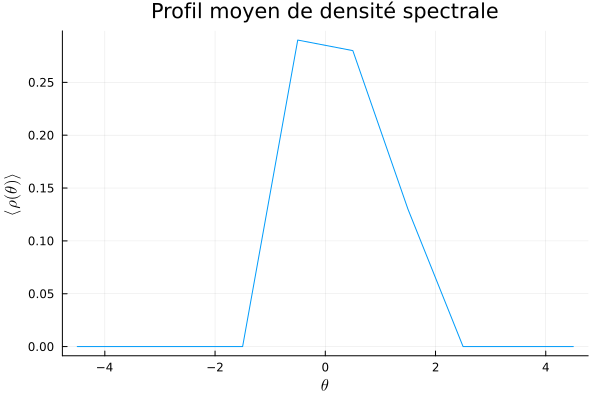

In [641]:
@time samples_hist, mean_rho, delta_rho, chi_matrix = run_monte_carlo_and_return_mean_density(N, 10, w_original)
println(sum(mean_rho*L*dtheta))
plot(theta_centers, mean_rho, xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)

  0.009623 seconds (78.13 k allocations: 9.574 MiB)
6.999999999999999


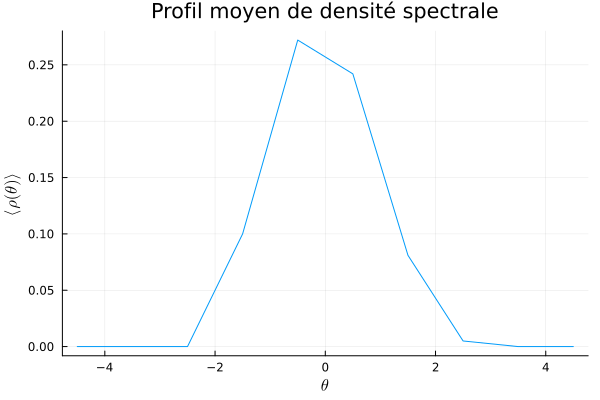

In [643]:
@time samples_hist, mean_rho, delta_rho, chi_matrix = run_monte_carlo_and_return_mean_density(N, 100, w_original)
println(sum(mean_rho*L*dtheta))
plot(theta_centers, mean_rho, xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)

  6.011934 seconds (72.51 M allocations: 8.900 GiB, 16.78% gc time)
6.999999999999996


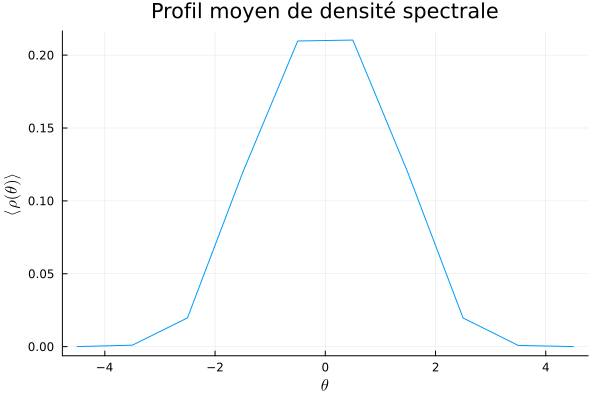

In [645]:
@time samples_hist, mean_rho, delta_rho, chi_matrix = run_monte_carlo_and_return_mean_density(N, 100_000, w_original)
println(sum(mean_rho*L*dtheta))
plot(theta_centers, mean_rho, xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)

 61.832080 seconds (724.72 M allocations: 88.981 GiB, 17.47% gc time)
6.999993999999995


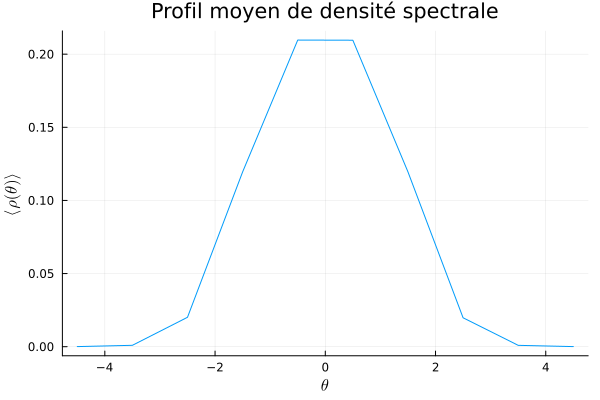

In [647]:
@time samples_hist, mean_rho, delta_rho, chi_matrix = run_monte_carlo_and_return_mean_density(N, nsteps, w_original)
println(sum(mean_rho*L*dtheta))
plot(theta_centers, mean_rho, xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)

🛠 : [██████████████████████████████] 100.0% (50000/50000)

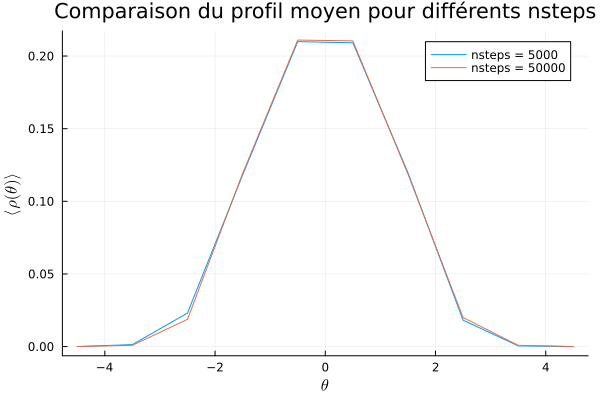

In [649]:
steps_list = [5_000 , 50_000]
plot()
for steps in steps_list
    samples_hist_tmp, mean_rho_tmp, _, _ = run_monte_carlo_and_return_mean_density(N, steps, w_original)
    plot!(theta_centers, mean_rho_tmp, label="nsteps = $steps")
    print_acceptance_bar(steps, steps_list[end])
end
xlabel!(L"\theta")
ylabel!(L"\langle \rho(\theta) \rangle")
title!("Comparaison du profil moyen pour différents nsteps")


🛠 : [██████████████████████████████] 100.0% (20/20)1190.593776 seconds (14.49 G allocations: 1.738 TiB, 15.63% gc time)


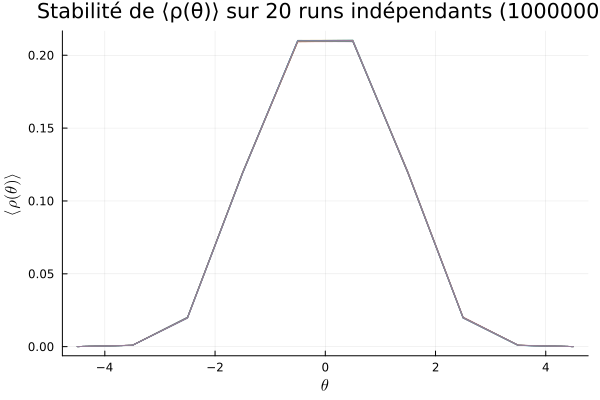

In [651]:
using Plots

nrepeats = 20
all_mean_rhos = []

@time for i in 1:nrepeats
    _, mean_rho, _, _ = run_monte_carlo_and_return_mean_density(N, nsteps , w_original)
    push!(all_mean_rhos, mean_rho)
    print_acceptance_bar(i, nrepeats)
end

# Tracer toutes les courbes de moyenne
plot()
for rho in all_mean_rhos
    plot!(theta_centers, rho, label="", alpha=0.5)
end

xlabel!(L"\theta")
ylabel!(L"\langle \rho(\theta) \rangle")
title!("Stabilité de ⟨ρ(θ)⟩ sur $nrepeats runs indépendants ($nsteps )")


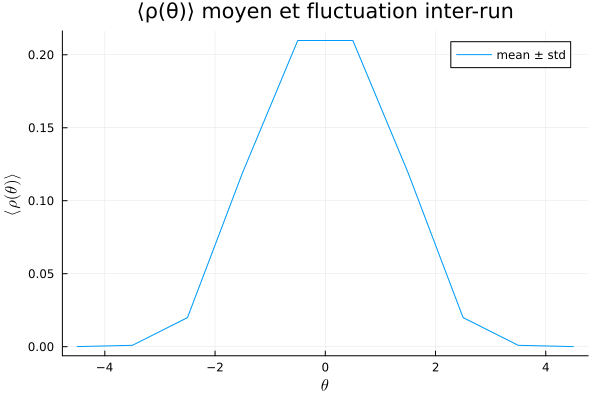

In [652]:
using Statistics

# Convertir en matrice (chaque ligne = un repeat)
rho_matrix = reduce(vcat, [rho' for rho in all_mean_rhos])

mean_profile = mean(rho_matrix, dims=1)[:]
std_profile = std(rho_matrix, dims=1)[:]

plot(theta_centers, mean_profile, ribbon=std_profile, label="mean ± std")
xlabel!(L"\theta")
ylabel!(L"\langle \rho(\theta) \rangle")
title!("⟨ρ(θ)⟩ moyen et fluctuation inter-run")


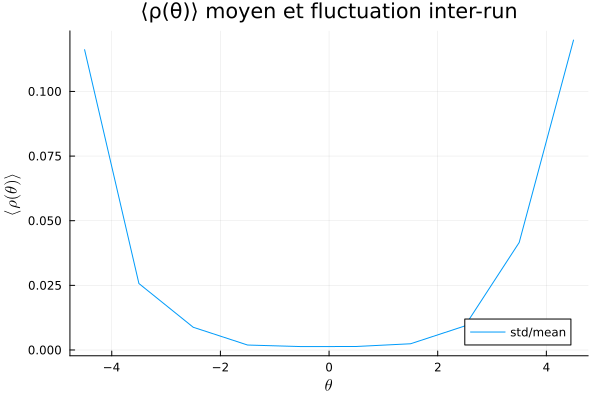

In [653]:
plot(theta_centers, std_profile./mean_profile, label="std/mean")
xlabel!(L"\theta")
ylabel!(L"\langle \rho(\theta) \rangle")
title!("⟨ρ(θ)⟩ moyen et fluctuation inter-run")

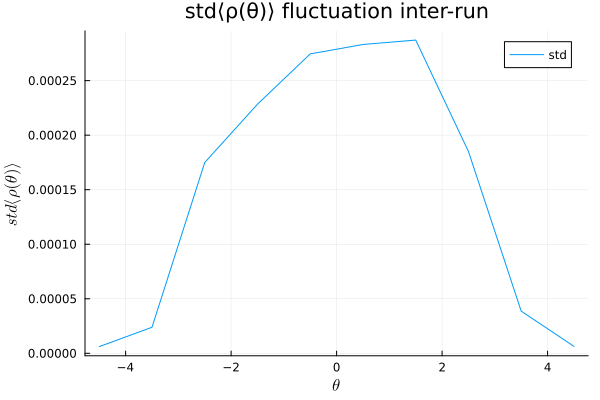

In [657]:
plot(theta_centers, std_profile, label="std")
xlabel!(L"\theta")
ylabel!(L"std\langle \rho(\theta) \rangle")
title!("std⟨ρ(θ)⟩ fluctuation inter-run")

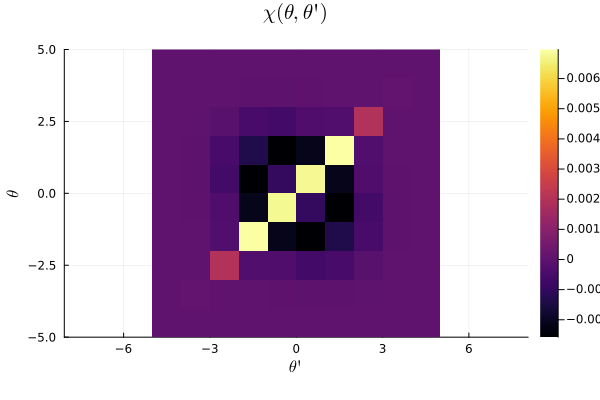

In [659]:
# Affichage de chi(\theta,\theta')
heatmap(theta_centers, theta_centers, chi_matrix, xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta')", colorbar=true, aspect_ratio=1)

# Suceptibilité 

## Fonction perturbation w

In [21]:
function make_w_with_perturbation(theta_centers, eps, theta_prime_idx)
    theta_prime = theta_centers[theta_prime_idx]
    width = theta_centers[2] - theta_centers[1]
    delta_window = width / 2
    function w_perturbed(lamb)
        correction = zeros(length(lamb))
        mask = abs.(lamb .- theta_prime) .< delta_window
        correction[findall(mask)] .= eps
        return w_original.(lamb) .+ correction
    end
    return w_perturbed
end

function w_perturbed_factory(theta_centers, theta_prime_idx,  w_original  , eps)
    theta_prime = theta_centers[theta_prime_idx]
    width = theta_centers[2] - theta_centers[1]
    delta_window = width / 2

    function w_func(lamb)
        correction = eps .* (abs.(lamb .- theta_prime) .< delta_window)
        return w_original.(lamb) .+ correction
    end

    return w_func
end


w_perturbed_factory (generic function with 1 method)

## test de eps

🛠 : [██████████████████████████████] 100.0% (2/2)

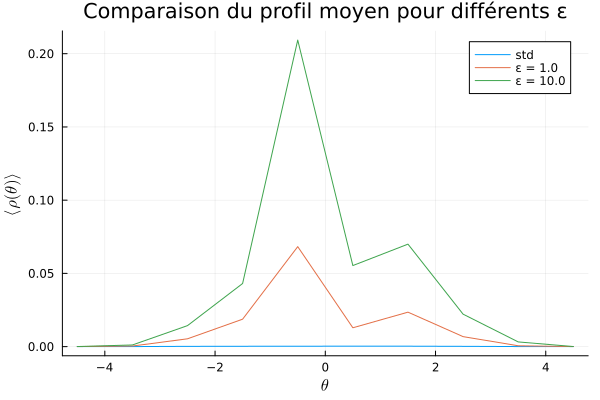

In [666]:
_, mean_rho_0, _, chi_matrix_0 = run_monte_carlo_and_return_mean_density(N, nsteps,  w_original)

eps_list = [1e0, 1e1]
plot()
plot!(theta_centers,std_profile, label="std")
for (j, eps) in enumerate(eps_list)
    w = w_perturbed_factory(theta_centers, Int(nbins / 2), w_original  , eps)
    _, mean_rho_eps, _, _ = run_monte_carlo_and_return_mean_density(N, nsteps, w)
    plot!(theta_centers, abs.(mean_rho_eps .- mean_rho_0) , label="ε = $eps")
    print_acceptance_bar(j, length(eps_list))
end
xlabel!(L"\theta")
ylabel!(L"\langle \rho(\theta) \rangle")
title!("Comparaison du profil moyen pour différents ε")


🛠 : [██████████████████████████████] 100.0% (26/26)

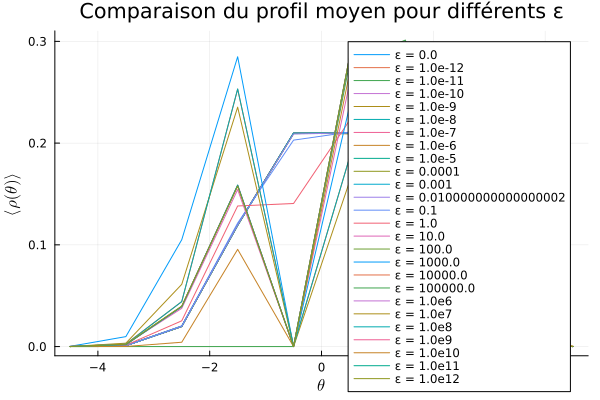

In [667]:
_, mean_rho_0, _, chi_matrix_0 = run_monte_carlo_and_return_mean_density(N, nsteps, w_original)

eps_list = [0.0, 0.1, 0.2, 0.4, 0.8, 1.6 , 3.2 , 6.4 , 12.8 , 25.6 ,  ]
# Liste automatique des eps (progression géométrique)
eps_list = [0.0; 1 * 10.0 .^ (-12:12)]  # Cela donne 0.0, 0.1, 0.2, ..., 25.6
distances = Float64[]  # Pour stocker les distances à mean_rho_0

plot()
for (j, eps) in enumerate(eps_list)
    w = w_perturbed_factory(theta_centers, Int(nbins / 2), w_original  , eps)
    _, mean_rho_eps, _, _ = run_monte_carlo_and_return_mean_density(N, nsteps, w)
    
    # Tracé du profil
    plot!(theta_centers, mean_rho_eps, label="ε = $eps")
    
    # Calcul et stockage de la distance
    dist = norm(mean_rho_eps .- mean_rho_0)
    push!(distances, dist)

    print_acceptance_bar(j, length(eps_list))
end

xlabel!(L"\theta")
ylabel!(L"\langle \rho(\theta) \rangle")
title!("Comparaison du profil moyen pour différents ε")

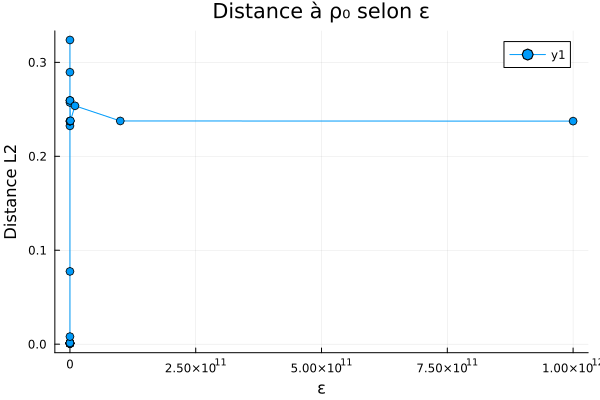

In [668]:
# Tracer la distance en fonction de ε
plot(eps_list, distances, marker=:o, xlabel="ε", ylabel="Distance L2", title="Distance à ρ₀ selon ε")

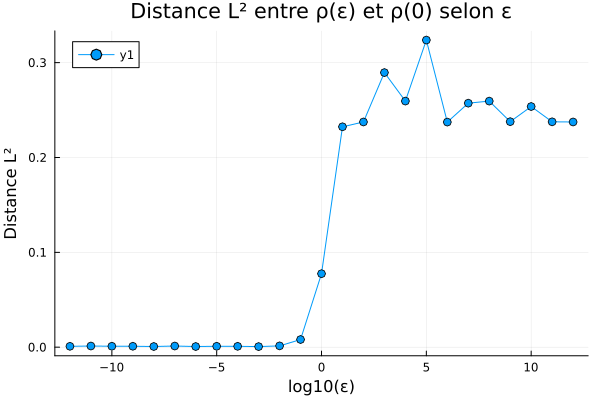

In [669]:
# Tracé de la distance L² en fonction de ε (log10)
plot(log10.(eps_list[2:end]), distances[2:end], marker=:o,
     xlabel="log10(ε)", ylabel="Distance L²",
     title="Distance L² entre ρ(ε) et ρ(0) selon ε")

## Execution

In [675]:
# Approximation de la dérivée fonctionnelle de \u03c7(\u03b8,\u03b8')
eps = 1.0e-1
chi_from_derivative = []
#w = w_original
_, mean_rho_0, _, chi_matrix_0 = run_monte_carlo_and_return_mean_density(N, nsteps,  w_original)

for j in 1:nbins
    #w = make_w_with_perturbation(theta_centers, eps, j)
    _, mean_rho_eps_m, _, _ = run_monte_carlo_and_return_mean_density(N, nsteps, w_perturbed_factory(theta_centers, j, w_original  , -eps))
    w = w_perturbed_factory(theta_centers, j, w_original  , eps)
#    p = plot(theta_centers, w.(theta_centers)- w_original.(theta_centers), xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)
#    display(p)
#    p1 = plot(theta_centers,  w_original.(theta_centers), xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)
#    plot!(p1, theta_centers,  w.(theta_centers), xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)
#    display(p1)
    _, mean_rho_eps, _, _ = run_monte_carlo_and_return_mean_density(N, nsteps, w)
    chi_col_j = - (mean_rho_eps .- mean_rho_eps_m) ./ (2*eps) ./ L
    #chi_col_j = - (mean_rho_eps .- mean_rho_0) ./ (w.(theta_centers[j])- w_original.(theta_centers[j])) ./ L 
    push!(chi_from_derivative, chi_col_j)
    print_acceptance_bar(j, nbins)
end
chi_from_derivative = reduce(hcat, chi_from_derivative)

# Affichage du profil moyen de densité
#plot(theta_centers, mean_rho, xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)
#grid!(true)

# Affichage de chi(\theta,\theta')
#heatmap(theta_centers, theta_centers, chi_matrix, xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta')", colorbar=true, aspect_ratio=1)

# Comparaison des deux chi
#heatmap(theta_centers, theta_centers, chi_from_derivative, xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta') (fonctionnelle)", colorbar=true, aspect_ratio=1)

🛠 : [██████████████████████████████] 100.0% (10/10)

10×10 Matrix{Float64}:
  1.095e-5    -2.4e-6       5.0e-7      …   2.7e-6      -3.5e-7
 -3.9e-6       8.615e-5     1.815e-5        1.23e-5     -2.105e-5
  0.0001189   -4.58e-5      0.00196625      6.83e-5     -5.02e-5
  0.0003106    0.0003357   -0.00045725     -7.93e-5     -0.0002651
 -7.465e-5    -0.0004979   -0.0004183      -0.000207     7.43e-5
 -0.00014015  -0.00034305  -0.00050405  …  -0.0001692    5.63e-5
 -0.00031375   0.0001557   -0.00045135      1.485e-5     0.00029425
  9.315e-5     0.00028515  -0.00013815      0.00022705  -9.2e-5
 -7.5e-7       1.92e-5     -1.91e-5         0.00013175  -6.95e-6
 -4.5e-7       7.15e-6      3.0e-6         -1.2e-6       1.095e-5

In [29]:
# Approximation de la dérivée fonctionnelle de \u03c7(\u03b8,\u03b8')
eps = 1.0e-1
_, mean_rho_0, _, chi_matrix_0 = run_monte_carlo_and_return_mean_density(N, Int(nsteps/100),  w_original)
function run_chi_from_derivative(N, nsteps, w_original , eps ) 
    chi_from_derivative = []
    #w = w_original
    
    
    for j in 1:nbins
        #w = make_w_with_perturbation(theta_centers, eps, j)
        _, mean_rho_eps_m, _, _ = run_monte_carlo_and_return_mean_density(N, nsteps, w_perturbed_factory(theta_centers, j, w_original  , -eps))
        w = w_perturbed_factory(theta_centers, j, w_original  , eps)
    #    p = plot(theta_centers, w.(theta_centers)- w_original.(theta_centers), xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)
    #    display(p)
    #    p1 = plot(theta_centers,  w_original.(theta_centers), xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)
    #    plot!(p1, theta_centers,  w.(theta_centers), xlabel=L"\theta", ylabel=L"\langle \rho(\theta) \rangle", label="", title="Profil moyen de densité spectrale", legend=false)
    #    display(p1)
        _, mean_rho_eps, _, _ = run_monte_carlo_and_return_mean_density(N, nsteps, w)
        chi_col_j = - (mean_rho_eps .- mean_rho_eps_m) ./ (2*eps) ./ L
        #chi_col_j = - (mean_rho_eps .- mean_rho_0) ./ (w.(theta_centers[j])- w_original.(theta_centers[j])) ./ L 
        push!(chi_from_derivative, chi_col_j)
        print_acceptance_bar(j, nbins)
    end
    chi_from_derivative = reduce(hcat, chi_from_derivative)
    return chi_from_derivative
end 

run_chi_from_derivative (generic function with 1 method)

In [31]:
using Plots  # <-- doit être ici, au top-level

function plot_norm_chi_vs_eps(N, nsteps, w_original, eps_list)
    norms = Float64[]

    for eps in eps_list
        chi = run_chi_from_derivative(N, nsteps, w_original, eps)
        residual = (chi_matrix_0 .- chi)./chi_matrix_0
        valid_mask = .!isnan.(residual) .& .!isinf.(residual)
        norm_chi = norm(residual[valid_mask])  # norme Frobenius
        push!(norms, norm_chi)
        println("ε = $eps → ||χ-χ0/χ0|| = $norm_chi")
    end

    plot(eps_list, norms,
        xlabel = L"\epsilon",
        ylabel = L"\left\| \frac{\delta \langle \rho \rangle}{\delta w} \right\|",
        xscale = :log10,
        yscale = :log10,
        marker = :circle,
        label = "",
        title = "Norme de la réponse linéaire vs ε"
    )
end


plot_norm_chi_vs_eps (generic function with 1 method)

🛠 : [██████████████████████████████] 100.0% (10/10)ε = 1.0e-5 → ||χ-χ0/χ0|| = 3.5953269919215776e7
🛠 : [██████████████████████████████] 100.0% (10/10)ε = 0.010000000000000002 → ||χ-χ0/χ0|| = 31617.221919026295
🛠 : [██████████████████████████████] 100.0% (10/10)ε = 10.0 → ||χ-χ0/χ0|| = 814.8161026165562
🛠 : [██████████████████████████████] 100.0% (10/10)ε = 10000.0 → ||χ-χ0/χ0|| = 11.013691654679347


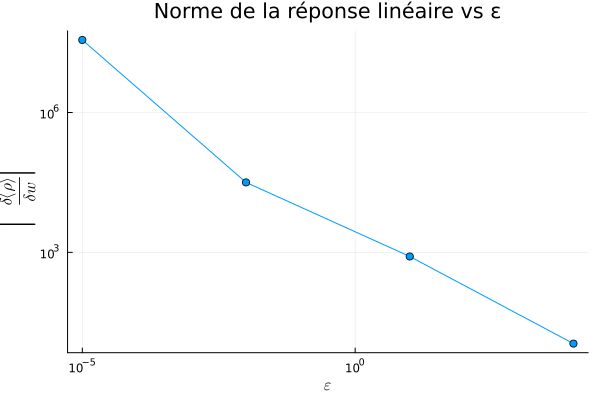

In [678]:
eps_list = 10.0 .^ (-5:3:5)  # Par exemple : [1e-5, 3.16e-5, ..., 1e-1]
plot_norm_chi_vs_eps(N, nsteps, w_original, eps_list)

# Comparaison

🛠 : [██████████████████████████████] 100.0% (10/10)

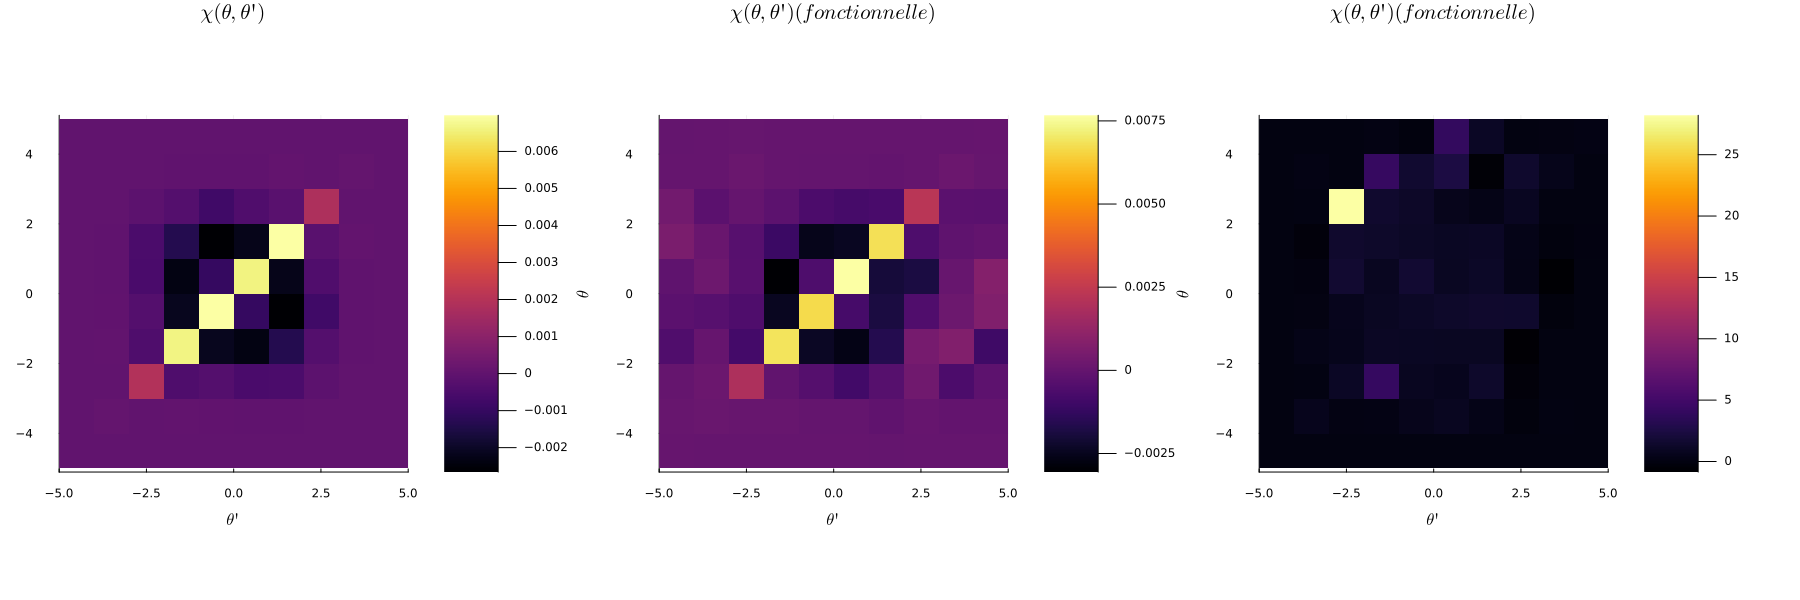

In [33]:
chi_from_derivative = run_chi_from_derivative(N, 10*nsteps, w_original, 1.0e-2)
# Affichage de chi(\theta,\theta')
p1 = heatmap(theta_centers, theta_centers, chi_matrix_0, xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta')", colorbar=true, aspect_ratio=1)
# Comparaison des deux chi
p2 = heatmap(theta_centers, theta_centers, chi_from_derivative, xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta') (fonctionnelle)", colorbar=true, aspect_ratio=1)
# Comparaison des deux chi
p3 = heatmap(theta_centers, theta_centers, (chi_matrix_0 .+ 1.0e-10)./(chi_from_derivative .+ 1.0e-10), xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta') (fonctionnelle)", colorbar=true, aspect_ratio=1)

# Créer la figure composée
plt = plot(p1, p2, p3, layout=(1, 3), size=(1800, 600))


In [34]:
# Sauvegarder l'image
savefig(plt, "figure_fluctuations.png")

"/Users/themezeguillaume/Documents/Application/data/Fluctuation_Pi/figure_fluctuations.png"

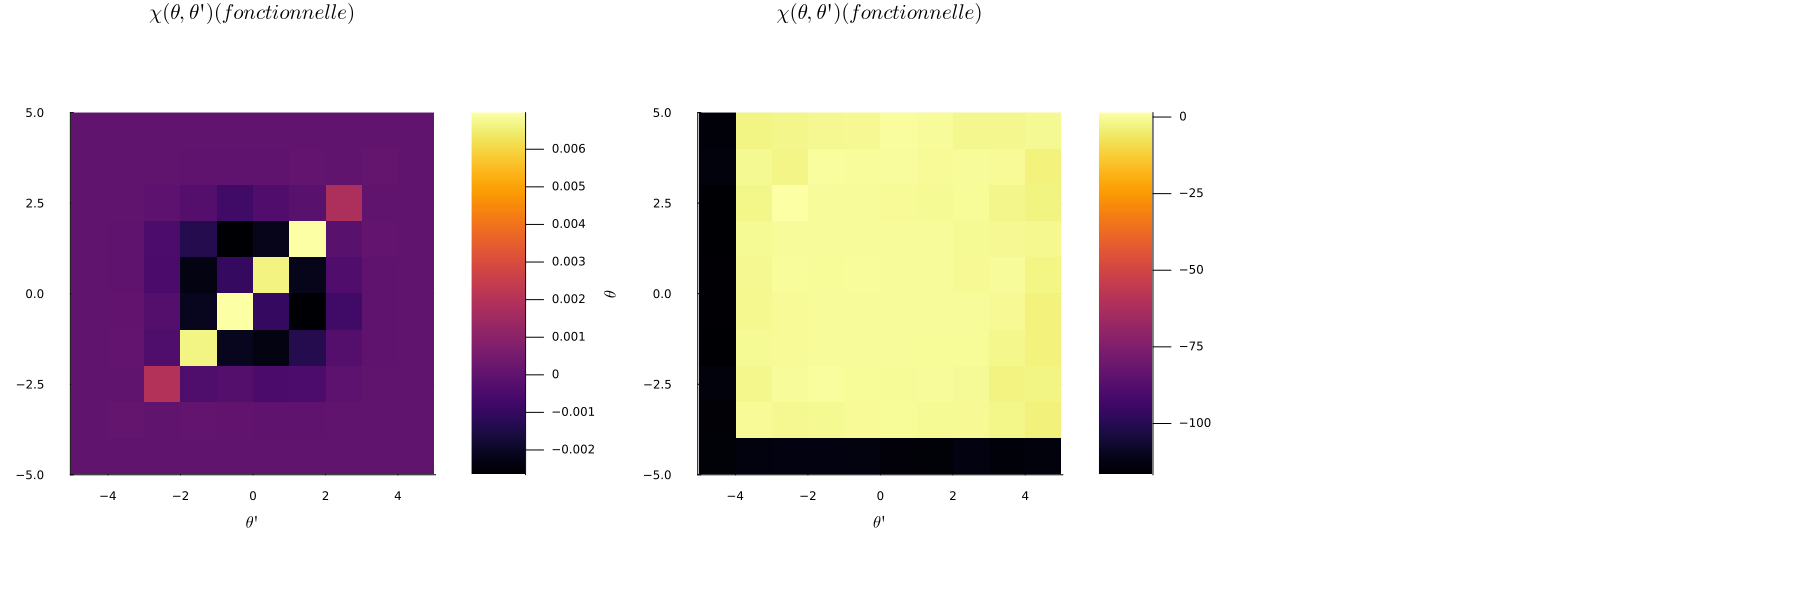

In [38]:
# Comparaison des deux chi
p1 = heatmap(theta_centers, theta_centers,chi_matrix_0 .+ 1.0e-10, xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta') (fonctionnelle)", colorbar=true, aspect_ratio=1)
# Comparaison des deux chi
p2 = heatmap(theta_centers, theta_centers,log.(abs.(((chi_matrix_0 .+ 1.0e-120)./(chi_from_derivative .+ 1.0e-120))))/log(10), xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta') (fonctionnelle)", colorbar=true, aspect_ratio=1)

plot(p1, p2, layout=(1, 3), size=(1800, 600))

In [40]:
## facteur de proportionalité 

In [46]:
using Statistics

# Masque pour ne garder que les points où le ratio est dans une plage raisonnable
mask = (abs.(chi_from_derivative) .> 1e-100) .& (abs.(chi_matrix_0) .< 2e1)
mask = (chi_matrix_0 .> -0.5) .& (chi_matrix_0 .< 2e-1)

x = copy(chi_from_derivative[mask])
y = copy(chi_matrix_0[mask])



# Régression sans biais : y ≈ a * x
factor_estimate = sum(x .* y) / sum(x .* x)


0.930077097641102

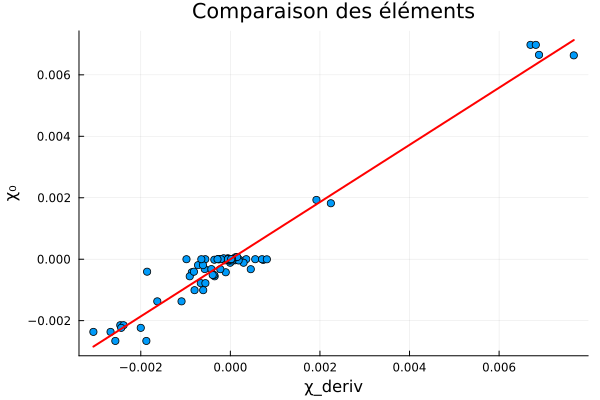

In [48]:
scatter(vec(x), vec(y),
    xlabel="χ_deriv", ylabel="χ₀", title="Comparaison des éléments",
    label="", legend=false)
plot!(x -> factor_estimate * x, lw=2, color=:red, label="α⋅x")  # ligne y = α x


In [694]:
residual = (chi_matrix_0 .- factor_estimate .* chi_from_derivative)./chi_matrix_0
valid_mask = .!isnan.(residual) .& .!isinf.(residual)
norm(abs.(residual[valid_mask]))

31220.637402096036

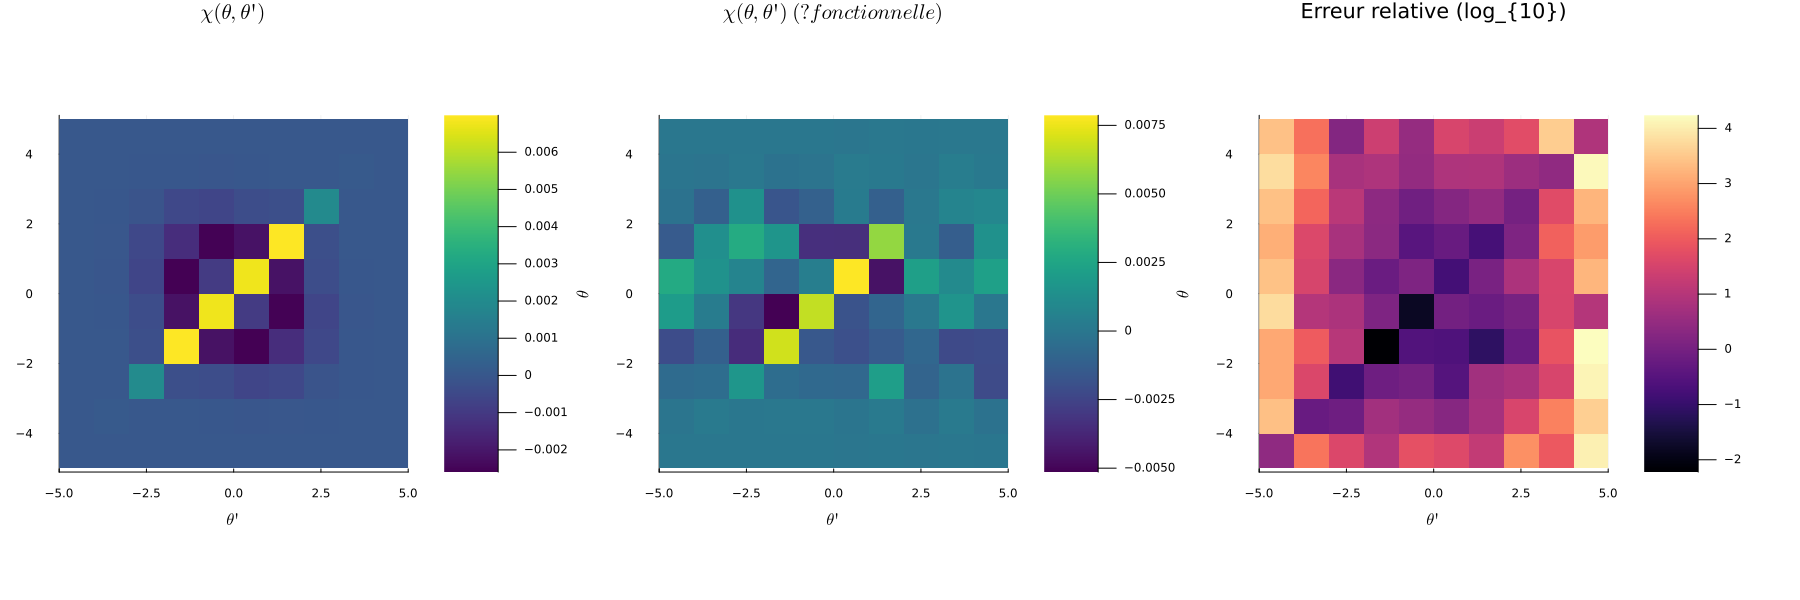

In [696]:
using Plots
yticks = xticks = (-3:1:1, ["10^{-3}", "10^{-2}", "10^{-1}", "1", "10"])
colorbar_ticks = (-20:5:0, ["10^{-20}", "10^{-15}", "10^{-10}", "10^{-5}", "1"])

# Heatmap de la matrice directe
p1 = heatmap(
    theta_centers, theta_centers, chi_matrix_0,
    xlabel=L"\theta'", ylabel=L"\theta",
    title=L"\chi(\theta,\theta')",
    colorbar=true, aspect_ratio=1, color=:viridis
)

# Heatmap de la version fonctionnelle
p2 = heatmap(
    theta_centers, theta_centers, factor_estimate .* chi_from_derivative,
    xlabel=L"\theta'", ylabel=L"\theta",
    title=L"\chi(\theta,\theta')\ (\text{fonctionnelle})",
    colorbar=true, aspect_ratio=1, color=:viridis
)

# Heatmap de l'erreur logarithmique relative
relative_error = log.(
    abs.((chi_matrix_0 .- factor_estimate .* chi_from_derivative) ./ chi_matrix_0) .+ 1e-20
) / log(10)

p3 = heatmap(
    theta_centers, theta_centers, relative_error,
    xlabel=L"\theta'", ylabel=L"\theta",
    title="Erreur relative (log_{10})",
    colorbar=true, aspect_ratio=1, color=:magma
)

# Affichage final
plot(p1, p2, p3, layout=(1, 3), size=(1800, 600))



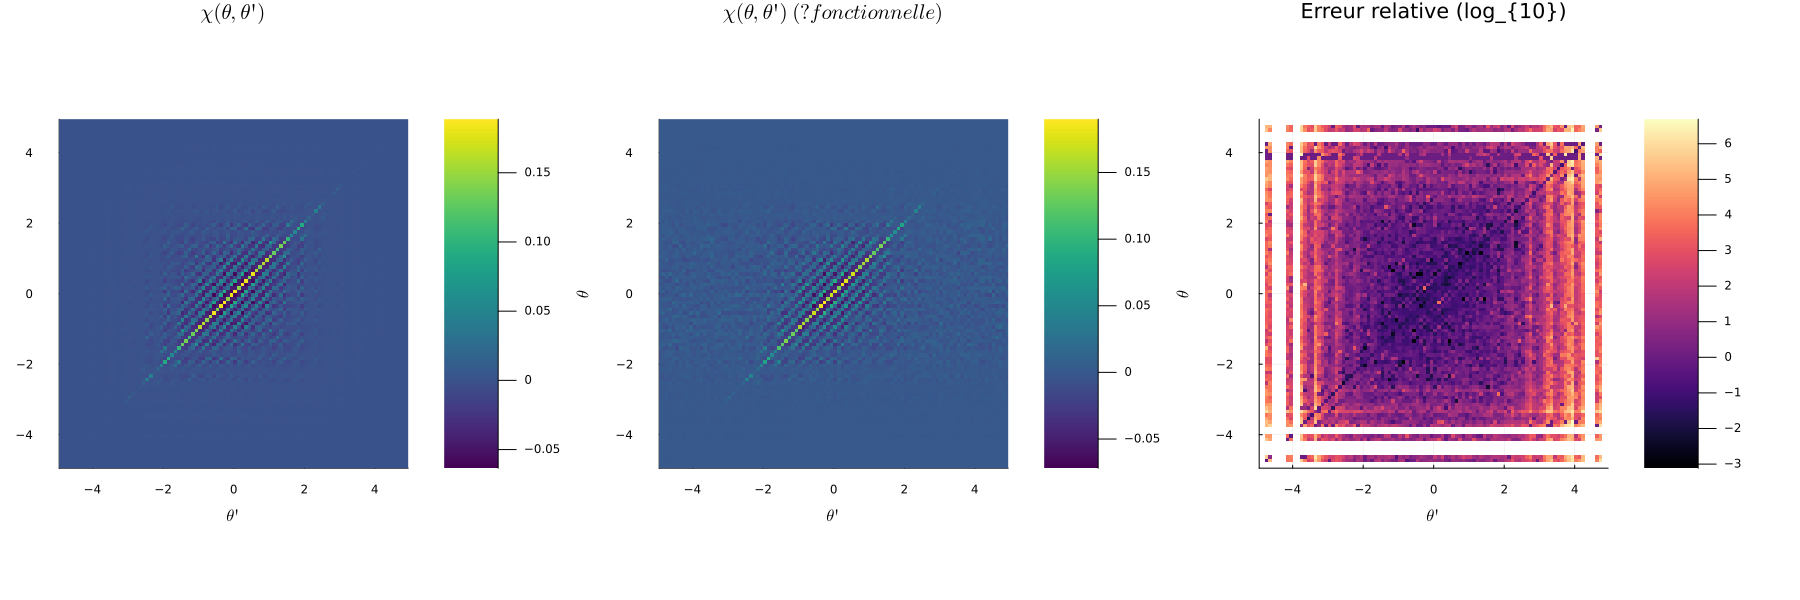

In [616]:
xlims = (minimum(theta_centers), maximum(theta_centers))
ylims = xlims
ticks_log10 = (-20:5:0, ["10^{-20}", "10^{-15}", "10^{-10}", "10^{-5}", "1"])

p1 = heatmap(theta_centers, theta_centers, chi_matrix_0,
    xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta')",
    colorbar=true, aspect_ratio=1, color=:viridis,
    xlims=xlims, ylims=ylims
)

p2 = heatmap(theta_centers, theta_centers, factor_estimate .* chi_from_derivative,
    xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta')\ (\text{fonctionnelle})",
    colorbar=true, aspect_ratio=1, color=:viridis,
    xlims=xlims, ylims=ylims,
    colorbar_ticks=:auto
)

relative_error = log.(abs.((chi_matrix_0 .- factor_estimate .* chi_from_derivative) ./ chi_matrix_0) .+ 1e-20) / log(10)

p3 = heatmap(theta_centers, theta_centers, relative_error,
    xlabel=L"\theta'", ylabel=L"\theta", title="Erreur relative (log_{10})",
    colorbar=true, aspect_ratio=1, color=:magma,
    xlims=xlims, ylims=ylims,
    colorbar_ticks=ticks_log10
)

plot(p1, p2, p3, layout=(1, 3), size=(1800, 600))


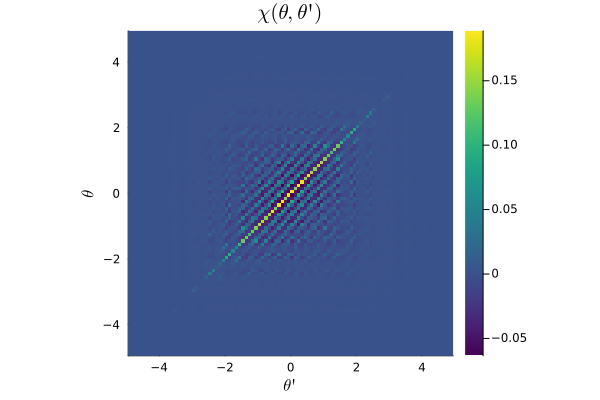

In [618]:
heatmap(theta_centers, theta_centers, chi_matrix_0,
    xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta')",
    colorbar=true, aspect_ratio=1, color=:viridis,
    xlims=xlims, ylims=ylims
)

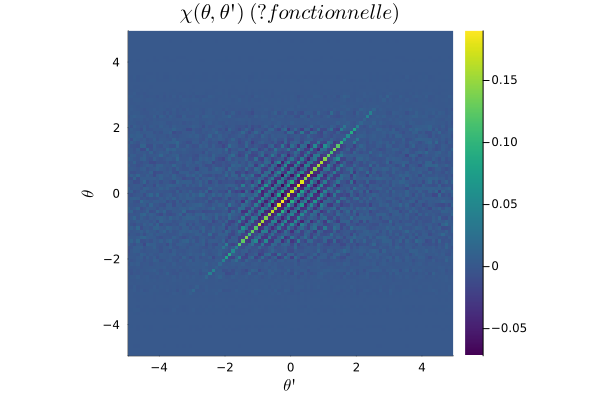

In [622]:
heatmap(theta_centers, theta_centers, factor_estimate .* chi_from_derivative,
    xlabel=L"\theta'", ylabel=L"\theta", title=L"\chi(\theta,\theta')\ (\text{fonctionnelle})",
    colorbar=true, aspect_ratio=1, color=:viridis,
    xlims=xlims, ylims=ylims,
    colorbar_ticks=:auto)

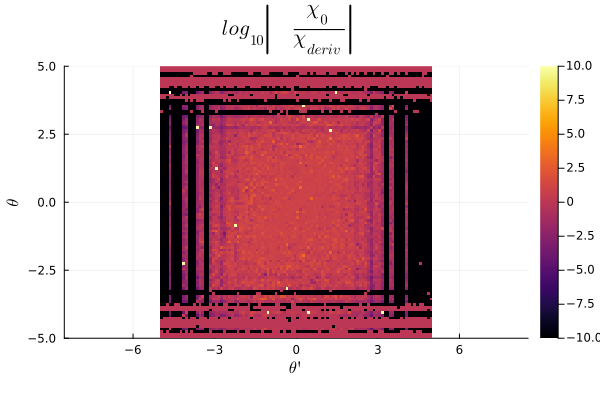

In [554]:
using Plots

# Calcul du log10 des rapports en évitant log(0)
ratio_matrix = (chi_matrix_0 .+ 1e-120) ./ (chi_from_derivative .+ 1e-120)
log_ratio = log10.(abs.(ratio_matrix) .+ 1e-12)  # 1e-12 pour éviter log(0)

# Heatmap avec réglage des bornes de la couleur (color scale)
heatmap(theta_centers, theta_centers, log_ratio,
    xlabel=L"\theta'", ylabel=L"\theta",
    title=L"log_{10} \left| \frac{\chi_0}{\chi_{deriv}} \right|",
    colorbar=true, aspect_ratio=1,
    clims = (-10, 10))  # exemple : couleurs entre 10^{-3} et 10^3


In [ ]:
plot(vec(log_ratio))

In [ ]:
threshold = 1e10  # à ajuster selon ton échelle
mask = abs.(chi_from_derivative) .< threshold
x_clean = vec(chi_from_derivative)[mask[:]]
y_clean = vec(chi_matrix_0)[mask[:]]

factor_estimate = sum(x_clean .* y_clean) / sum(x_clean .* x_clean)


In [ ]:
using LsqFit

model(α, x) = α .* x
fit = curve_fit(model, x_clean, y_clean, [1.0])
factor_estimate = fit.param[1]


In [ ]:
ratios = (chi_matrix_0 .+ 1e-120) ./ (chi_from_derivative .+ 1e-120)
valid_mask = (ratios .> 0.1) .& (ratios .< 10.0) .& mask

x_valid = vec(chi_from_derivative)[valid_mask[:]]
y_valid = vec(chi_matrix_0)[valid_mask[:]]

factor_estimate = sum(x_valid .* y_valid) / sum(x_valid .* x_valid)


In [ ]:
x_log = log.(abs.(x_clean))
y_log = log.(abs.(y_clean))

factor_log = mean(y_log .- x_log)  # facteur multiplicatif dans le log

factor_estimate = exp(factor_log)


In [ ]:
maximum(abs.(chi_matrix_0))


In [ ]:
maximum(abs.(chi_from_derivative))

In [ ]:

mean((chi_matrix_0 .+ 1.0e-120)./(chi_from_derivative .+ 1.0e-120))

In [ ]:
factor_estimate = mean((chi_matrix_0 .+ 1e-120) ./ (chi_from_derivative .+ 1e-120))


In [ ]:
residuals = chi_matrix_0 .- factor_estimate .* chi_from_derivative
max_residual = maximum(abs.(residuals))
relative_error = max_residual / maximum(abs.(chi_matrix_0))


In [ ]:
using Statistics

numerator = sum(chi_matrix_0 .* chi_from_derivative)
denominator = sum(chi_from_derivative .^ 2)
factor_estimate = numerator / denominator



In [ ]:
# Matrice corrigée avec le facteur estimé
chi_scaled = factor_estimate * chi_from_derivative

# Comparaison brute
maximum_abs_diff = maximum(abs.(chi_matrix_0 .- chi_scaled))
mean_abs_diff = mean(abs.(chi_matrix_0 .- chi_scaled))
rel_error = mean(abs.((chi_matrix_0 .- chi_scaled) ./ (chi_matrix_0 .+ 1e-120)))  # relative error


In [ ]:
using Plots

heatmap(chi_matrix_0, title="chi_matrix_0")



In [ ]:
heatmap(chi_scaled, title="factor_estimate * chi_from_derivative")


In [ ]:
heatmap(chi_matrix_0 - chi_scaled, title="Residual Error (difference)")

In [ ]:
ratio_matrix = (chi_matrix_0 .+ 1e-120) ./ (chi_from_derivative .+ 1e-120)

using StatsBase
ratio_stats = (mean = mean(ratio_matrix), std = std(ratio_matrix), max = maximum(ratio_matrix), min = minimum(ratio_matrix))

# Affichage visuel
histogram(ratio_matrix[:], bins=100, title="Histogram of chi_matrix_0 / chi_from_derivative", xlabel="Ratio", ylabel="Frequency")


In [ ]:
using Plots, Statistics

factor_estimate = mean((chi_matrix_0 .+ 1e-120) ./ (chi_from_derivative .+ 1e-120))
residuals = chi_matrix_0 .- factor_estimate .* chi_from_derivative
relative_errors = residuals ./ maximum(abs.(chi_matrix_0))

histogram(vec(relative_errors), bins=100,
    xlabel="Erreur relative", ylabel="Fréquence",
    title="Histogramme des erreurs relatives",
    label="")


In [ ]:
heatmap(abs.(residuals), title="|Δχ| = |χ₀ - α⋅χ_deriv|",
        xlabel="Colonne", ylabel="Ligne", colorbar_title="Valeur")


In [ ]:
scatter(vec(factor_estimate.*chi_from_derivative), vec(chi_matrix_0),
    xlabel="χ_deriv", ylabel="χ₀", title="Comparaison des éléments",
    label="", legend=false)
#plot!(x -> factor_estimate * x, lw=2, color=:red, label="α⋅x")  # ligne y = α x


# Système : chaîne de spins d'Ising 1D dans un champ aléatoire

In [ ]:
using Random
using Statistics
using LinearAlgebra
using Plots

# Paramètres
L = 10                      # Taille du système (10 spins)
β = 1.0                     # Inverse température
n_steps = 10_000            # Nombre de pas de Monte Carlo
ε = 1e-4                    # Perturbation pour la dérivée numérique

# Fonctions utilitaires
function energy(config, h)
    # Hamiltonien : - Σ_i σ_i σ_{i+1} - Σ_i h_i σ_i (bord périodique)
    E = -sum(config .* circshift(config, -1)) - sum(h .* config)
    return E
end

function monte_carlo_average(h; β=β, n_steps=n_steps)
    config = rand([-1, 1], L)
    samples = zeros(L, n_steps)
    
    for step in 1:n_steps
        i = rand(1:L)
        config_trial = copy(config)
        config_trial[i] *= -1
        ΔE = energy(config_trial, h) - energy(config, h)
        if rand() < exp(-β * ΔE)
            config = config_trial
        end
        samples[:, step] = config
    end
    return samples
end

# ➤ Monte Carlo sans champ
h0 = zeros(L)
samples = monte_carlo_average(h0)
mean_config = mean(samples; dims=2)[:]                    # ⟨σ_i⟩
corr_matrix = (samples * samples') / n_steps - mean_config * mean_config'  # ⟨σ_i σ_j⟩ - ⟨σ_i⟩⟨σ_j⟩

# ➤ Réponse par dérivée numérique : χ_ij = d⟨σ_i⟩ / dh_j
response_matrix = zeros(L, L)
for j in 1:L
    h_plus  = copy(h0); h_plus[j] += ε
    h_minus = copy(h0); h_minus[j] -= ε
    mean_plus  = mean(monte_carlo_average(h_plus); dims=2)[:]
    mean_minus = mean(monte_carlo_average(h_minus); dims=2)[:]
    response_matrix[:, j] = (mean_plus .- mean_minus) / (2ε)
end

# ➤ Fluctuation-réponse : corr_matrix ≈ β⁻¹ × response_matrix
factor_est = sum(corr_matrix .* response_matrix) / sum(response_matrix .* response_matrix)
residual = corr_matrix .- β^(-1) .* response_matrix

# ➤ Vérification
println("Estimation du facteur de proportionnalité (doit ≈ 1/β) : ", factor_est)
println("Erreur max relative : ", maximum(abs.(residual ./ corr_matrix)))

# ➤ Affichage
p1 = heatmap(corr_matrix, title="Corrélations Monte Carlo", aspect_ratio=1)
p2 = heatmap(response_matrix, title="Réponse par dérivée", aspect_ratio=1)
p3 = heatmap(residual, title="Résidu (corr - β⁻¹ * resp)", aspect_ratio=1)

plot(p1, p2, p3, layout=(1, 3), size=(1800, 600))